In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Part 1

Load the dataset

Drop irrelevant columns

In [2]:
df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')

irrelevant_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge',
                      'ehail_fee', 'mta_tax', 'extra', 'fare_amount',
                      'congestion_surcharge']
df = df.drop(irrelevant_columns, axis=1)

C:\Users\mobin\AppData\Local\Temp\ipykernel_18048\3269505622.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')



Convert relevant columns to appropriate types

Handle specific values as requested

In [3]:
df['payment_type'] = df['payment_type'].astype(object)
df['trip_type'] = df['trip_type'].astype(object)


df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isnull()), 'payment_type'] = 1
df.loc[df['passenger_count'] > 4, 'payment_type'] = 6
df.loc[df['passenger_count'] > 4, 'trip_type'] = 3
df.dropna(subset=['VendorID'], inplace=True)


Convert pickup and dropoff datetime

Extract hour/day/month from pickup_datetime

Drop original datetime columns

In [4]:
df['pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['pickup_datetime'].dt.year == 2021]
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.day_name()
weekday_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
# Apply the mapping to the 'weekday' column
df['weekday'] = df['weekday'].map(weekday_mapping)


df['dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_month'] = df['dropoff_datetime'].dt.month


df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], inplace=True)

                                 column_name  percent_missing
VendorID                            VendorID         0.000000
lpep_pickup_datetime    lpep_pickup_datetime         0.000000
lpep_dropoff_datetime  lpep_dropoff_datetime         0.000000
PULocationID                    PULocationID         0.000000
DOLocationID                    DOLocationID         0.000000
passenger_count              passenger_count        19.926428
trip_distance                  trip_distance         0.000000
tip_amount                        tip_amount         0.000000
tolls_amount                    tolls_amount         0.000000
total_amount                    total_amount         0.000000
payment_type                    payment_type        16.344603
trip_type                          trip_type        19.926428
pickup_datetime              pickup_datetime         0.000000


Merge borough information into the main DataFrame

In [5]:
borough_df = pd.read_csv('Boroughs.csv')
df = df.merge(borough_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)

df = df.merge(borough_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)


Encode boroughs

In [6]:
df = pd.get_dummies(df, columns=['PU_Borough'], prefix=['PU'], drop_first=True)
df.drop([ 'PULocationID', 'DOLocationID', 'LocationID_x', 'LocationID_y','pickup_datetime', 'dropoff_datetime' ,'DO_Borough'], axis=1, inplace=True)
print(df.columns)

Index(['VendorID', 'passenger_count', 'trip_distance', 'tip_amount',
       'tolls_amount', 'total_amount', 'payment_type', 'trip_type',
       'pickup_hour', 'pickup_day', 'pickup_month', 'weekday', 'dropoff_hour',
       'dropoff_day', 'dropoff_month', 'PU_Brooklyn', 'PU_EWR', 'PU_Manhattan',
       'PU_Queens', 'PU_Staten Island'],
      dtype='object')


Handle missing value using regression or classification

In [7]:
df = df.apply(pd.to_numeric, errors='coerce')
for column in df.columns:
    null_percentage = df[column].isnull().mean()
    if 0.05 < null_percentage <= 0.3:
        missing_rows = df[df[column].isnull()]
        complete_rows = df[df[column].notnull()]

        features_to_drop = [column]
        if complete_rows[column].dtype in ['int64', 'float64']:
            model = HistGradientBoostingRegressor()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values


        else:
            model = HistGradientBoostingClassifier()
            model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
            predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
            df.loc[df[column].isnull(), column] = predicted_values

print(df.head())
print(df.info())

   VendorID  passenger_count  trip_distance  tip_amount  tolls_amount  \
0       2.0              1.0           1.01        0.00           0.0   
1       2.0              1.0           2.53        2.81           0.0   
2       2.0              1.0           1.12        1.00           0.0   
3       2.0              3.0           0.00        0.00           0.0   
4       2.0              3.0           0.00        0.00           0.0   

   total_amount  payment_type  trip_type  pickup_hour  pickup_day  \
0          6.80           2.0        1.0            0           1   
1         16.86           1.0        1.0            0           1   
2          8.30           1.0        1.0            0           1   
3        -52.80           3.0        1.0            0           1   
4         52.80           2.0        1.0            0           1   

   pickup_month  weekday  dropoff_hour  dropoff_day  dropoff_month  \
0             1        5             0            1              1   
1     


Calculate and display missing values percentage

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

                       column_name  percent_missing
VendorID                  VendorID              0.0
passenger_count    passenger_count              0.0
trip_distance        trip_distance              0.0
tip_amount              tip_amount              0.0
tolls_amount          tolls_amount              0.0
total_amount          total_amount              0.0
payment_type          payment_type              0.0
trip_type                trip_type              0.0
pickup_hour            pickup_hour              0.0
pickup_day              pickup_day              0.0
pickup_month          pickup_month              0.0
weekday                    weekday              0.0
dropoff_hour          dropoff_hour              0.0
dropoff_day            dropoff_day              0.0
dropoff_month        dropoff_month              0.0
PU_Brooklyn            PU_Brooklyn              0.0
PU_EWR                      PU_EWR              0.0
PU_Manhattan          PU_Manhattan              0.0
PU_Queens   

# Part 2


## 2.1

Heatmap of Activity Levels Throughout the Week

In [30]:
df_1=df[:100000]
df['Pickup_Borough'] = df.apply(
    lambda row: 'Brooklyn' if row['PU_Brooklyn'] == 1 else
                'EWR' if row['PU_EWR'] == 1 else
                'Manhattan' if row['PU_Manhattan'] == 1 else
                'Queens' if row['PU_Queens'] == 1 else
                'Staten Island' if row['PU_Staten Island'] == 1 else
                'Bronx', axis=1
)
green_taxi_trend = df.groupby([ 'Pickup_Borough','pickup_hour']).size().unstack(fill_value=0)
df_Spring= df[df['pickup_month'].isin([3, 4, 5])]
df_Summer=df[df['pickup_month'].isin([6,7,8])]
df_Fall=df[df['pickup_month'].isin([9,10,11])]
df_Winter =df[df['pickup_month'].isin([12,1,2])]


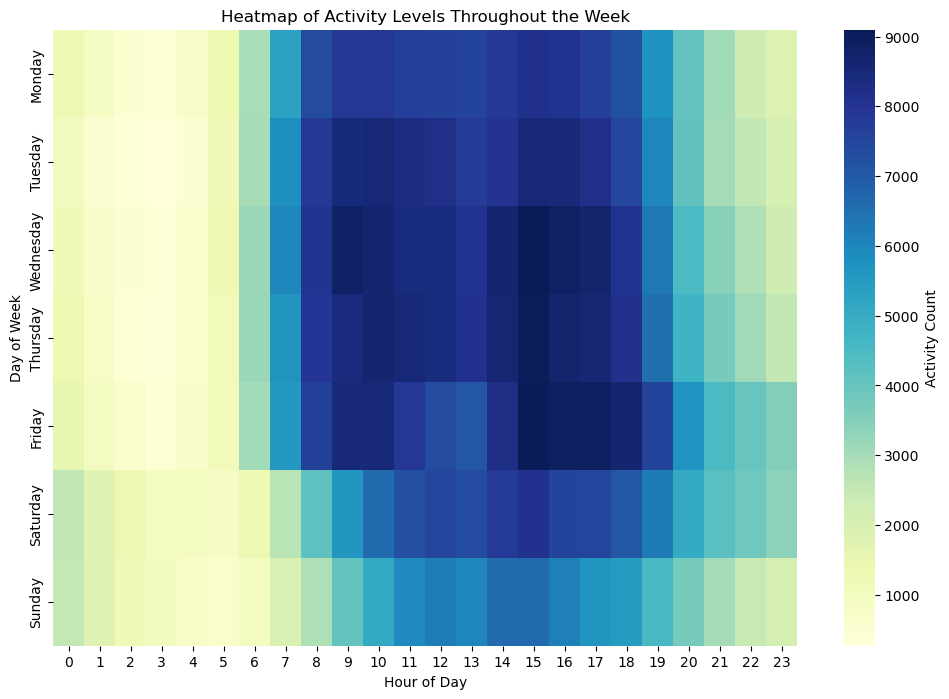

In [10]:

heatmap_data = df.groupby(['weekday', 'pickup_hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", cbar_kws={"label": "Activity Count"})
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Heatmap of Activity Levels Throughout the Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

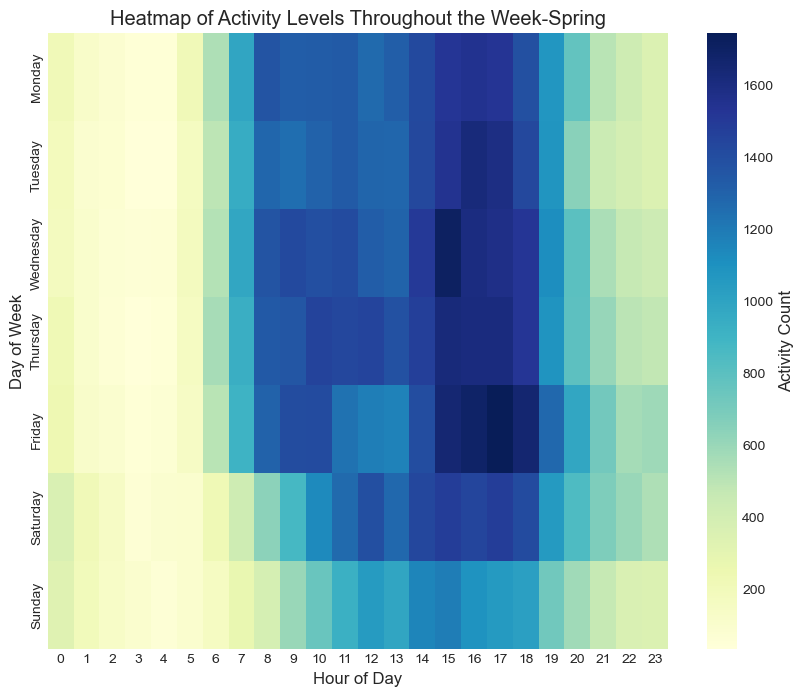

In [43]:
heatmap_data = df_Spring.groupby(['weekday', 'pickup_hour']).size().unstack()

plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", cbar_kws={"label": "Activity Count"})
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Heatmap of Activity Levels Throughout the Week-Spring")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

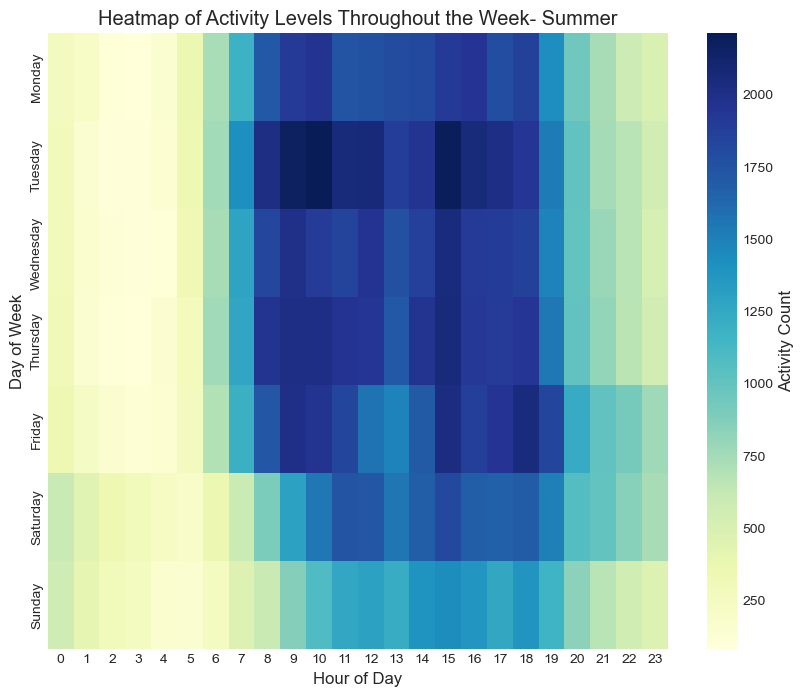

In [46]:

heatmap_data = df_Summer.groupby(['weekday', 'pickup_hour']).size().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", cbar_kws={"label": "Activity Count"})
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Heatmap of Activity Levels Throughout the Week- Summer")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

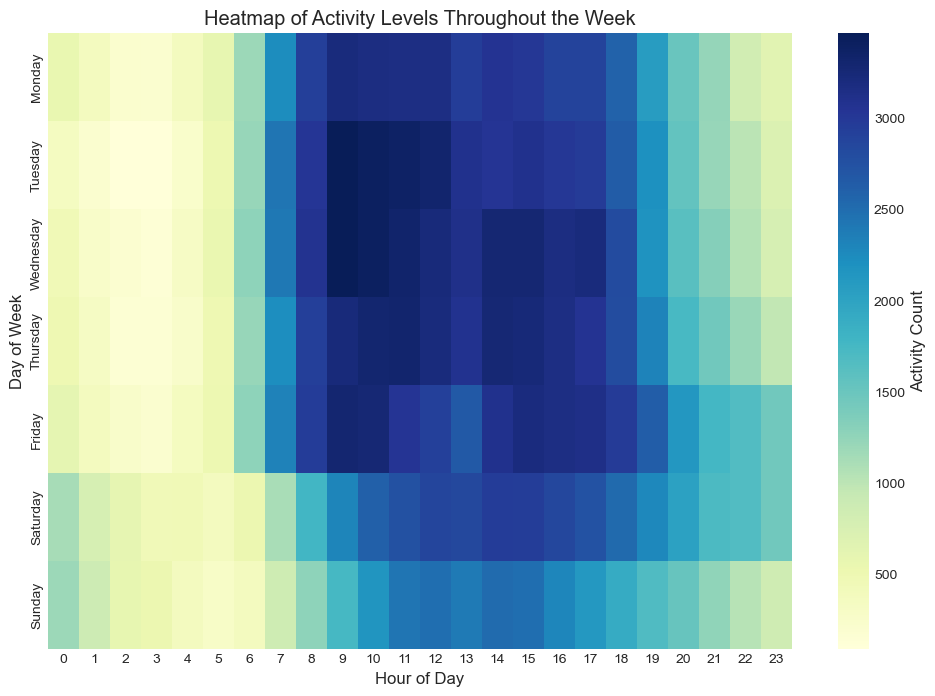

In [47]:
heatmap_data = df_Fall.groupby(['weekday', 'pickup_hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", cbar_kws={"label": "Activity Count"})
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Heatmap of Activity Levels Throughout the Week-Fall")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

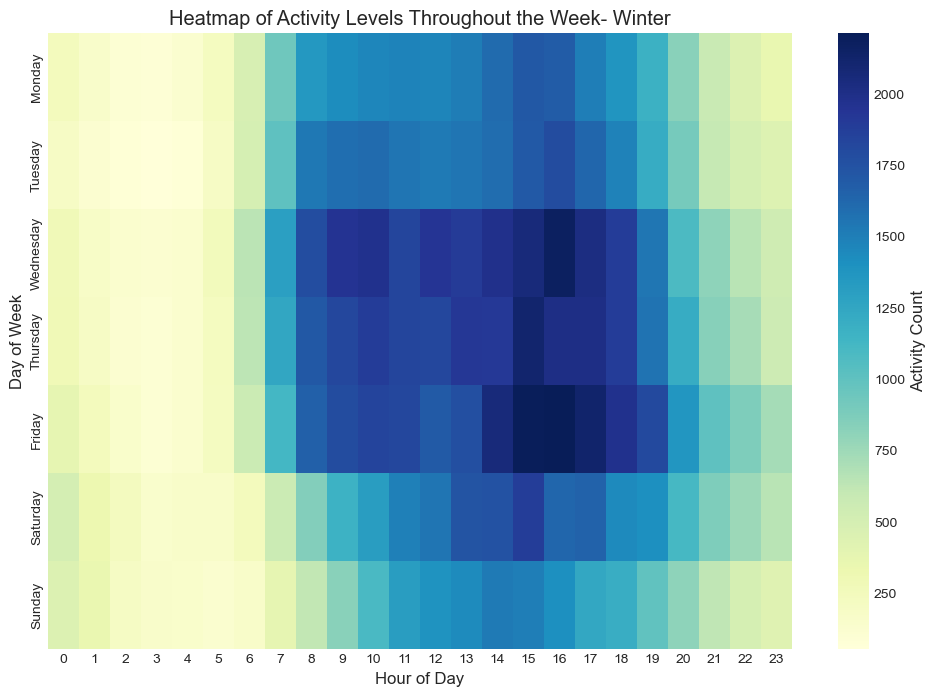

In [48]:

heatmap_data = df_Winter.groupby(['weekday', 'pickup_hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", cbar_kws={"label": "Activity Count"})
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Heatmap of Activity Levels Throughout the Week- Winter")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


## 2.2
Plotting the Payment Type Distribution by Hour 

Payment Type Distribution by Hour 

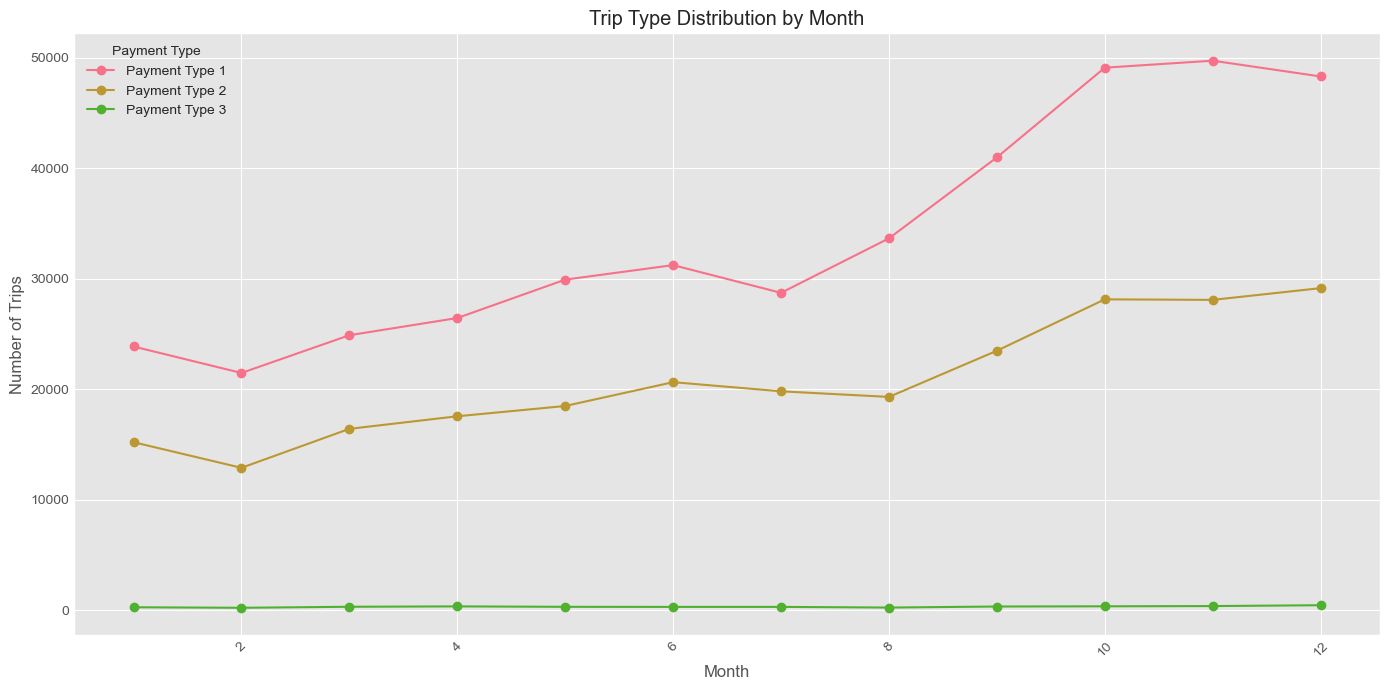

In [49]:
sns.set_style("whitegrid")
plt.style.use('ggplot')
sns.set_palette('husl')
trip_type_payment_distribution = df.groupby(['pickup_month', 'payment_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))
plt.plot(trip_type_payment_distribution[1], marker='o', label='Payment Type 1')
plt.plot(trip_type_payment_distribution[2], marker='o', label='Payment Type 2')
plt.plot(trip_type_payment_distribution[3], marker='o', label='Payment Type 3')

plt.title('Trip Type Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.legend(title='Payment Type')
plt.tight_layout()
plt.show()



Trip Type Distribution by Hour  

Plotting the Trip Type Distribution by Hour

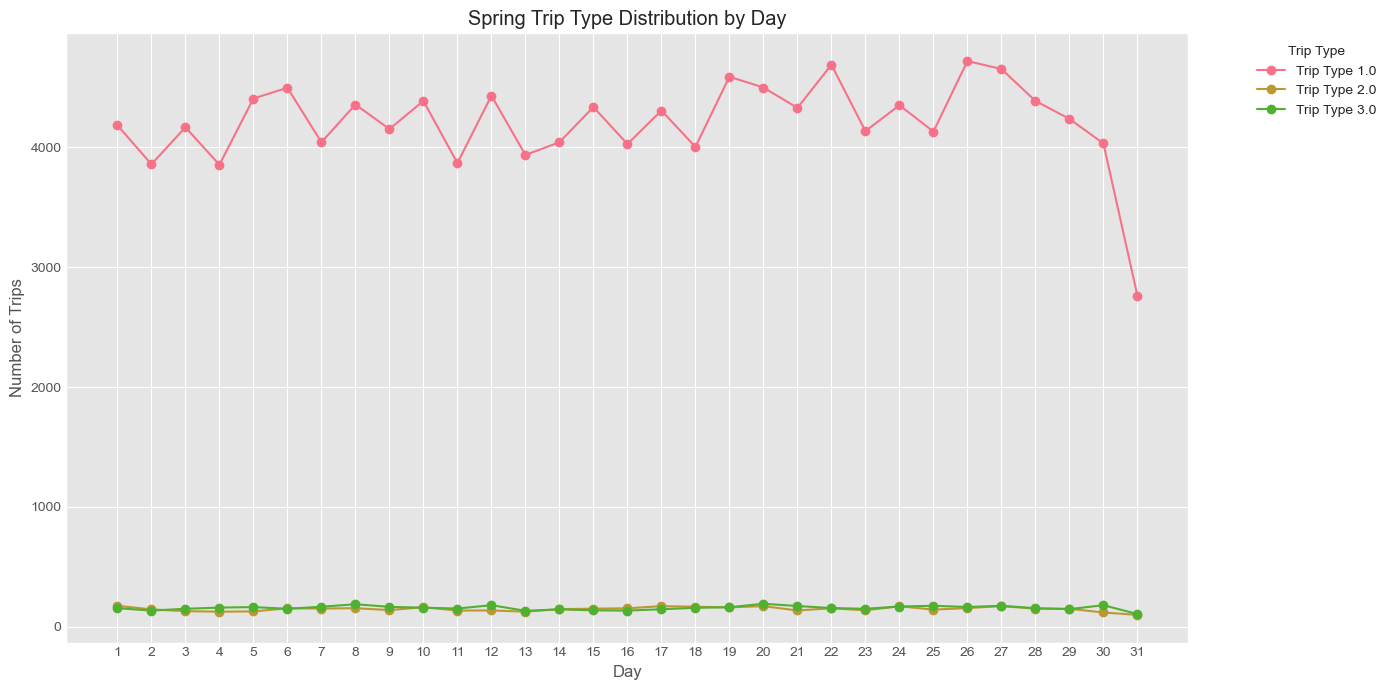

In [50]:
sns.set_style("whitegrid")
plt.style.use('ggplot')
sns.set_palette('husl')
trip_type_monthly_distribution = df_Spring.groupby(['pickup_day', 'trip_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))
for trip_type in trip_type_monthly_distribution.columns:
    plt.plot(
        trip_type_monthly_distribution.index, 
        trip_type_monthly_distribution[trip_type], 
        marker='o', 
        label=f'Trip Type {trip_type}'
    )
plt.title('Spring Trip Type Distribution by Day')
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.xticks(trip_type_monthly_distribution.index)
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

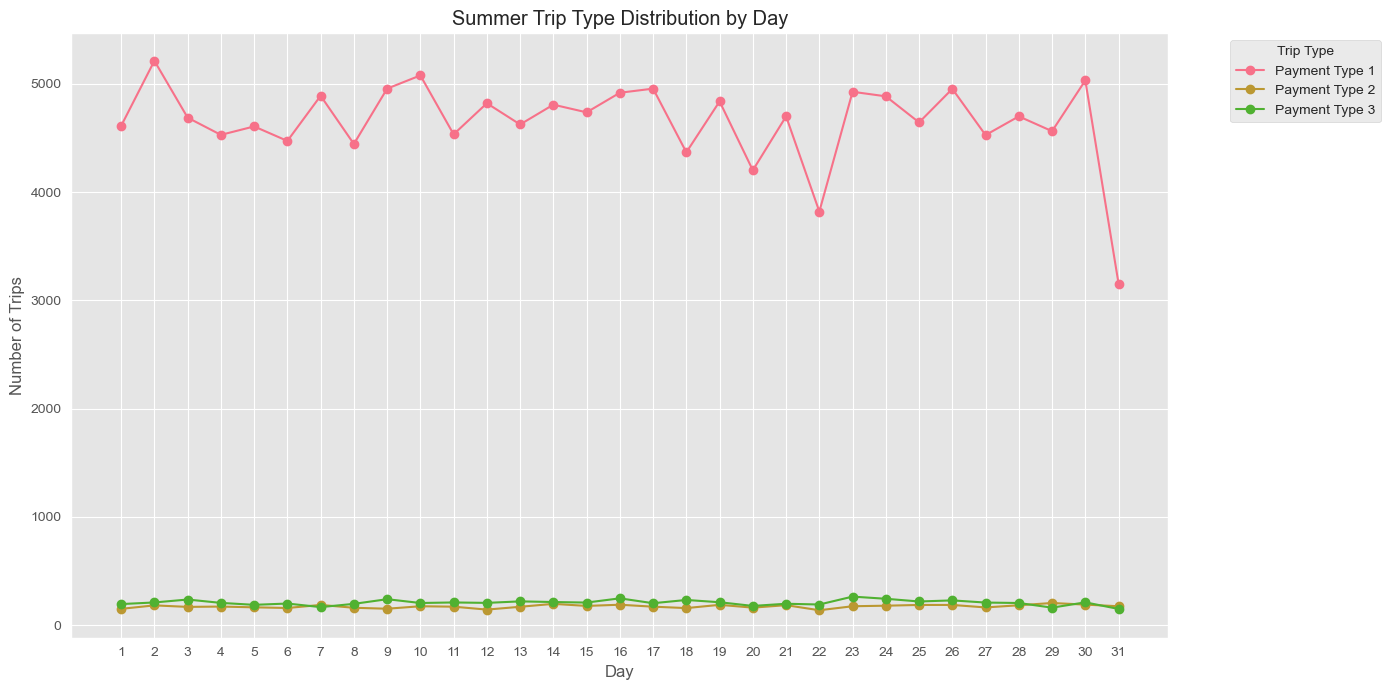

In [20]:
sns.set_style("whitegrid")
plt.style.use('ggplot')
sns.set_palette('husl')
trip_type_monthly_distribution = df_Summer.groupby(['pickup_day', 'trip_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))
plt.plot(trip_type_monthly_distribution[1], marker='o', label='Payment Type 1')
plt.plot(trip_type_monthly_distribution[2], marker='o', label='Payment Type 2')
plt.plot(trip_type_monthly_distribution[3], marker='o', label='Payment Type 3')
plt.title('Summer Trip Type Distribution by Day')
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.xticks(trip_type_monthly_distribution.index)  # استفاده از ماه‌های واقعی در محور افقی
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

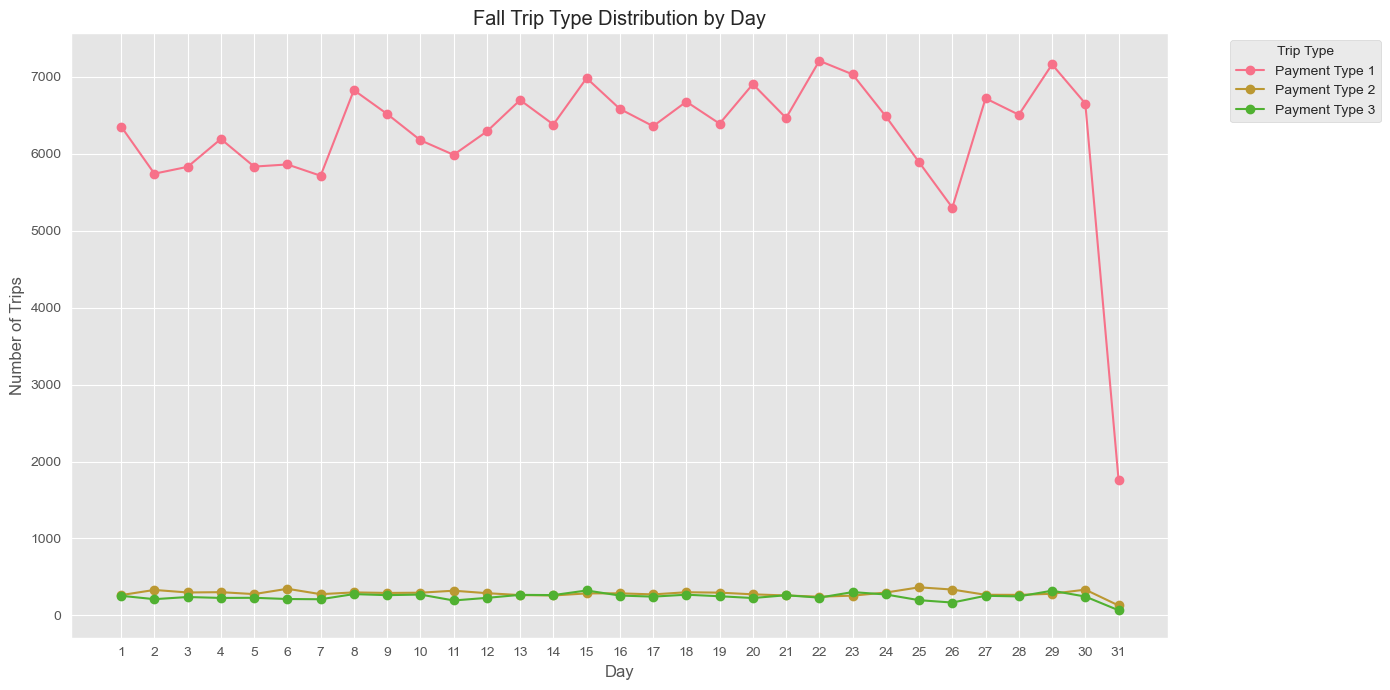

In [21]:
sns.set_style("whitegrid")
plt.style.use('ggplot')
sns.set_palette('husl')
trip_type_monthly_distribution = df_Fall.groupby(['pickup_day', 'trip_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))
plt.plot(trip_type_monthly_distribution[1], marker='o', label='Payment Type 1')
plt.plot(trip_type_monthly_distribution[2], marker='o', label='Payment Type 2')
plt.plot(trip_type_monthly_distribution[3], marker='o', label='Payment Type 3')
plt.title('Fall Trip Type Distribution by Day')
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.xticks(trip_type_monthly_distribution.index)  # استفاده از ماه‌های واقعی در محور افقی
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

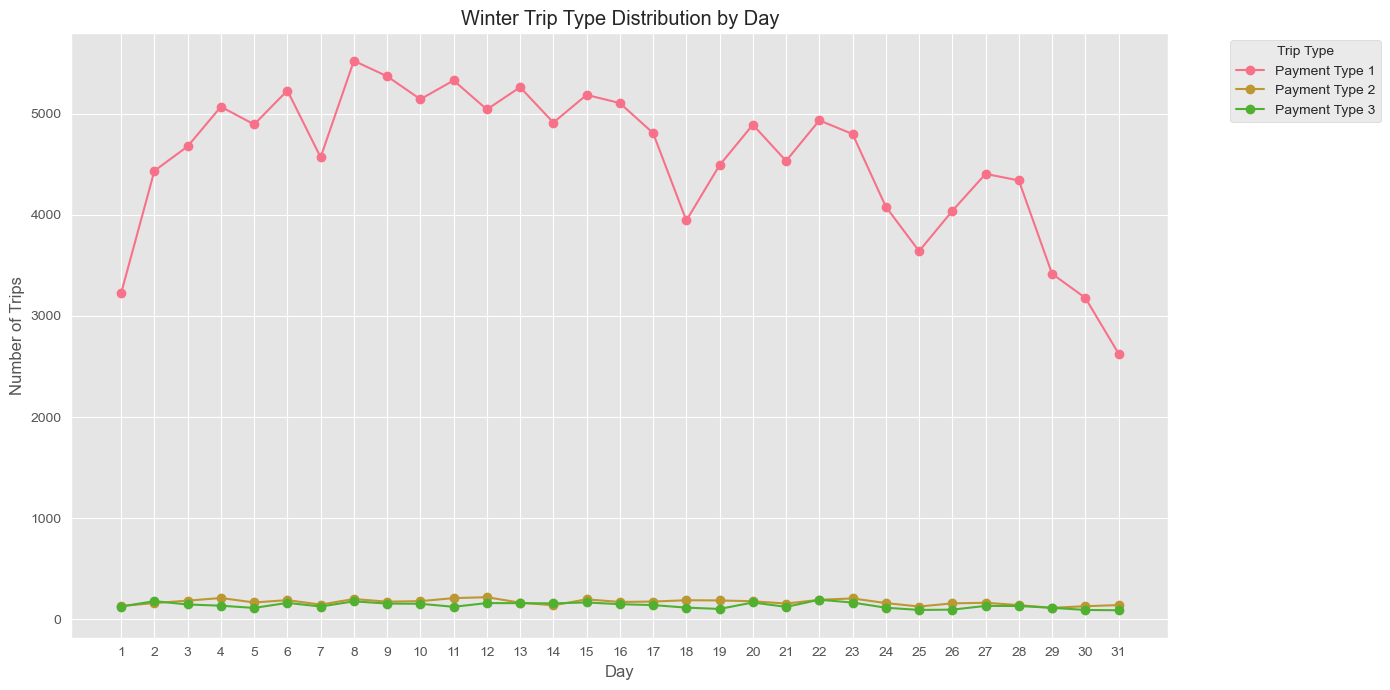

In [22]:
sns.set_style("whitegrid")
plt.style.use('ggplot')
sns.set_palette('husl')
trip_type_monthly_distribution = df_Winter.groupby(['pickup_day', 'trip_type']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 7))
plt.plot(trip_type_monthly_distribution[1], marker='o', label='Payment Type 1')
plt.plot(trip_type_monthly_distribution[2], marker='o', label='Payment Type 2')
plt.plot(trip_type_monthly_distribution[3], marker='o', label='Payment Type 3')
plt.title('Winter Trip Type Distribution by Day')
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.xticks(trip_type_monthly_distribution.index)  # استفاده از ماه‌های واقعی در محور افقی
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Discarding trips with trip type dispatch 

Analyzing green taxi usage by pickup hour trend

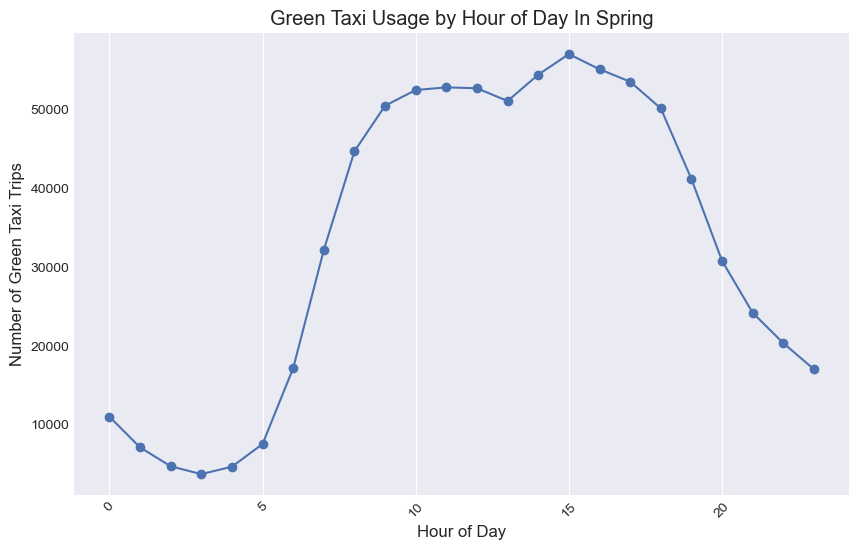

In [59]:
taxi_df = df[df['trip_type'] != 3]
green_taxi_usage = taxi_df.groupby('pickup_hour').size()
plt.figure(figsize=(10, 6))
green_taxi_usage.plot(kind='line',marker='o')
plt.title('Green Taxi Usage by Hour of Day In Spring')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Green Taxi Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Grouping by all dummy variables for boroughs and pickup hour

In [38]:
df['Pickup_Borough'] = df.apply(
    lambda row: 'Brooklyn' if row['PU_Brooklyn'] == 1 else
                'EWR' if row['PU_EWR'] == 1 else
                'Manhattan' if row['PU_Manhattan'] == 1 else
                'Queens' if row['PU_Queens'] == 1 else
                'Staten Island' if row['PU_Staten Island'] == 1 else
                'Bronx', axis=1
)
green_taxi_trend = df.groupby([ 'Pickup_Borough','pickup_month']).size().unstack(fill_value=0)

Plotting the trend of green taxi usage by boroughs

<Figure size 1400x700 with 0 Axes>

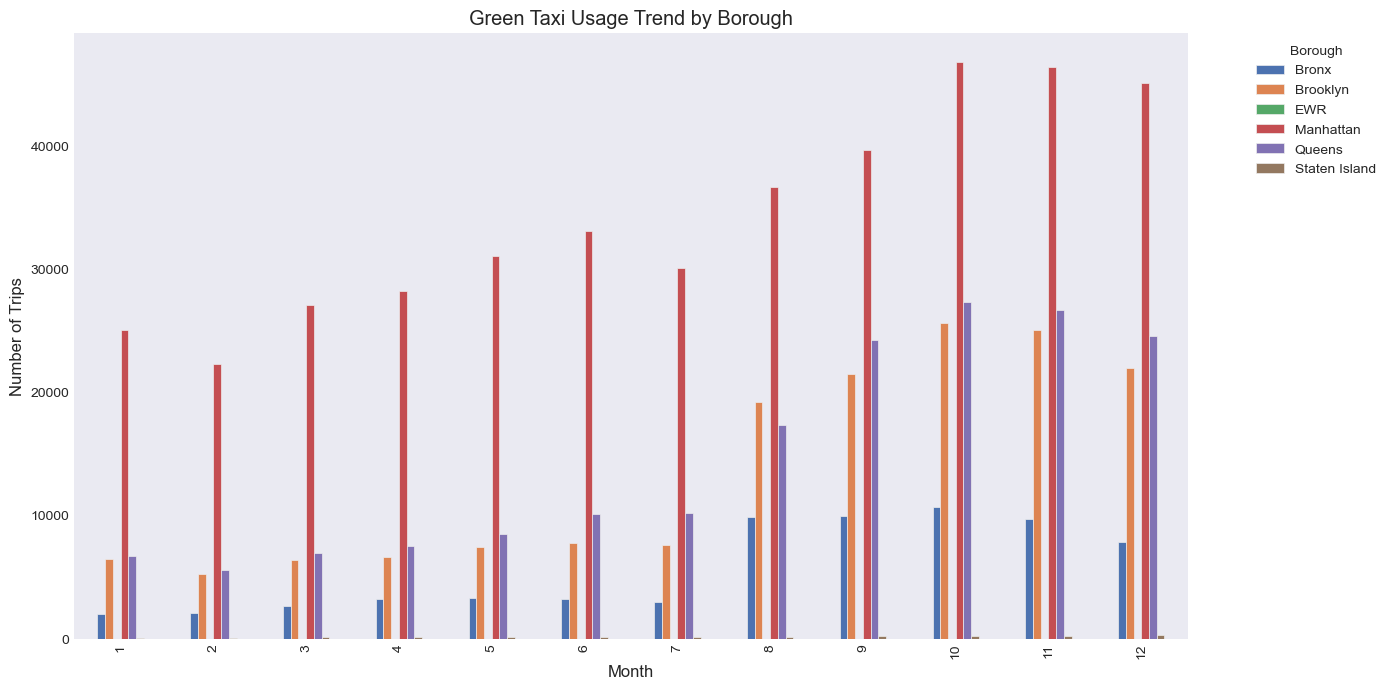

In [53]:
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')
green_taxi_trend.T.plot(kind='bar', figsize=(14, 7))
plt.title('Green Taxi Usage Trend by Borough')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


# Part 3
## 3.1
Correlation heatmap

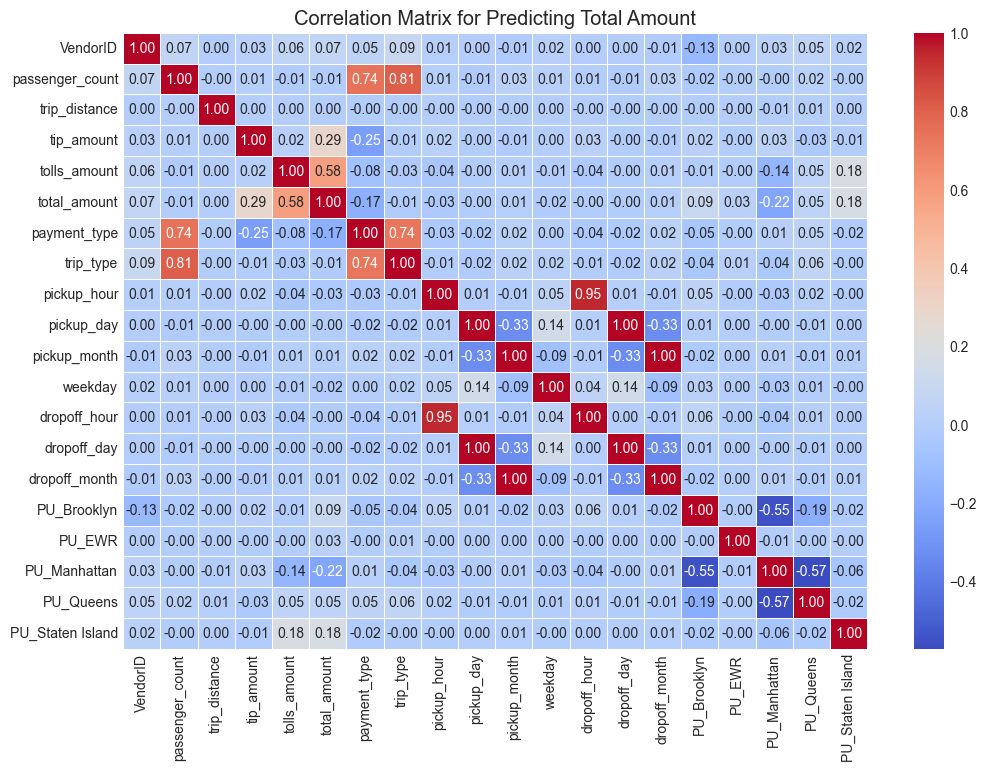

In [15]:
correlation_matrix = df_1.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Predicting Total Amount')
plt.show()

Printing columns with the highest correlation with total_amount

In [16]:
correlation_with_total = correlation_matrix['total_amount'].sort_values(ascending=False)
print("Top correlations with total_amount:")
print(correlation_with_total)

Top correlations with total_amount:
total_amount        1.000000
tolls_amount        0.583099
tip_amount          0.285300
PU_Staten Island    0.175760
PU_Brooklyn         0.092143
VendorID            0.069703
PU_Queens           0.050286
PU_EWR              0.028498
dropoff_month       0.008527
pickup_month        0.008454
trip_distance       0.003996
dropoff_hour       -0.002609
dropoff_day        -0.003699
pickup_day         -0.003827
passenger_count    -0.012551
trip_type          -0.014353
weekday            -0.017384
pickup_hour        -0.033084
payment_type       -0.174208
PU_Manhattan       -0.223615
Name: total_amount, dtype: float64


## 3.2
1. Backward feature selection

In [17]:

def backward_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    return list(selected_features)

backward_selected_features = backward_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Backward Selected Features:", backward_selected_features)


Backward Selected Features: ['tolls_amount', 'payment_type', 'trip_type', 'PU_EWR', 'PU_Staten Island']


2. Forward feature selection

In [18]:

def forward_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    model = LinearRegression()
    selected_features = []
    remaining_features = list(X.columns)
    while len(selected_features) < n_features and remaining_features:
        best_score = -np.inf
        best_feature = None
        for feature in remaining_features:
            trial_features = selected_features + [feature]
            scores = cross_val_score(model, X[trial_features], y, cv=5, scoring='r2')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_feature = feature
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
    return selected_features
forward_selected_features = forward_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Forward Selected features:", forward_selected_features)

Forward Selected features: ['tolls_amount', 'tip_amount', 'PU_Manhattan', 'PU_Queens', 'PU_Brooklyn']



3. Random forest feature selection

In [19]:

def random_forest_feature_selection(data, target_column='total_amount', n_features=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=X.columns)

    selected_features = feature_importances.nlargest(n_features).index.tolist()
    return selected_features
rf_selected_features = random_forest_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Random Forest Selected Features:", rf_selected_features)


Random Forest Selected Features: ['trip_distance', 'tip_amount', 'dropoff_hour', 'pickup_hour', 'payment_type']


4. Chi square feature selection

In [20]:
def chi_square_feature_selection(data, target_column='pct', n_features=5):    
    if data[target_column].dtype not in ['int64', 'int32', 'bool', 'uint8']:
        data[target_column] = pd.qcut(data[target_column], q=4, labels=False)
    X = data.drop(columns=[target_column])
    y = data[target_column]
    for column in X.columns:
        if X[column].dtype in ['float64', 'int64']:
            X[column] = pd.cut(X[column], bins=5, labels=False)
        X[column] = X[column].clip(lower=0)
    chi_selector = SelectKBest(score_func=chi2, k=n_features)
    X_kbest = chi_selector.fit_transform(X, y)
    selected_features = X.columns[chi_selector.get_support()]
    return selected_features
chi_selected_features = chi_square_feature_selection(df_1, target_column='total_amount', n_features=5)
print("Chi-Square Selected Features (Chi-Square):", list(chi_selected_features))

Chi-Square Selected Features (Chi-Square): ['tolls_amount', 'pickup_hour', 'dropoff_hour', 'PU_Brooklyn', 'PU_Manhattan']



## 3.3

In [21]:

df_1['tip_given'] = (df_1['tip_amount'] > 0).astype(int)
X = df_1.drop(columns=['tip_given', 'tip_amount'])  # حذف ستون‌های غیرضروری
y = df_1['tip_given']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



1. Decision Tree Classifier

In [22]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

Decision Tree Classifier Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     10669
           1       0.86      0.84      0.85      9331

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000

Accuracy: 0.862



2. Random Forest Classifier

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     10669
           1       0.86      0.93      0.90      9331

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000

Accuracy: 0.8985


3. XGBoost Classifier

In [24]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classifier Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

C:\Users\frequensy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     10669
           1       0.86      0.95      0.91      9331

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Accuracy: 0.9076


## 3.4

Function to train and evaluate linear regression model

Split data into training and testing sets

Train Linear Regression model

Evaluation with MSE and R^2


In [25]:
def evaluate_linear_regression(features, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2


Define target variable and features

Identify feature subsets from different selection methods

Evaluate Linear Regression for each feature subset

Convert results to a DataFrame

In [26]:
y = df_1['total_amount']
X = df_1.drop(columns=['total_amount'])


feature_selection_methods = {
    'Backward': backward_selected_features,
    'Forward': forward_selected_features,
    'Random Forest': rf_selected_features,
    'Chi-Square': list(chi_selected_features)
}


results = []
for method, features in feature_selection_methods.items():
    mse, r2 = evaluate_linear_regression(features, X, y)
    results.append({'Method': method, 'MSE': mse, 'R^2': r2})

results_df = pd.DataFrame(results)

Find the best feature set based on MSE

In [27]:
best_method = results_df.loc[results_df['MSE'].idxmin()]
best_features = feature_selection_methods[best_method['Method']]

print("Feature Selection Results:")
print(results_df)
print("\nBest Feature Set Based on MSE:")
print(f"Method: {best_method['Method']}, MSE: {best_method['MSE']}, R^2: {best_method['R^2']}")

Feature Selection Results:
          Method       MSE       R^2
0       Backward  1.102093  0.149395
1        Forward  0.999655  0.228457
2  Random Forest  1.093105  0.156332
3     Chi-Square  1.178561  0.090376

Best Feature Set Based on MSE:
Method: Forward, MSE: 0.9996547800784942, R^2: 0.2284574987603588



Integrate the best Linear Regression model with Random Forest and XGBoost for comparison
1. Train and evaluate the best Linear Regression model

In [28]:

X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 2. Random Forest Regressor

In [29]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

3. XGBoost Regressor

In [30]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

Comparison of models.

In [31]:
comparison_results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Mean Squared Error': [lr_mse, rf_mse, xgb_mse],
    'R^2 Score': [lr_r2, rf_r2, xgb_r2]
}
comparison_df = pd.DataFrame(comparison_results)

print("\nModel Comparison:")
print(comparison_df)
best_model = comparison_df.loc[comparison_df['Mean Squared Error'].idxmin()]


Model Comparison:
               Model  Mean Squared Error  R^2 Score
0  Linear Regression            0.999655   0.228457
1      Random Forest            0.155843   0.879719
2            XGBoost            0.155275   0.880158


Displaying the best model based on MSE.

In [32]:

print("\nBest Model Based on MSE:")
print(f"Method: {best_model['Model']}, MSE: {best_model['Mean Squared Error']:.4f}, R^2: {best_model['R^2 Score']:.4f}")


Best Model Based on MSE:
Method: XGBoost, MSE: 0.1553, R^2: 0.8802


Showing the 10 most important features and how important they are.

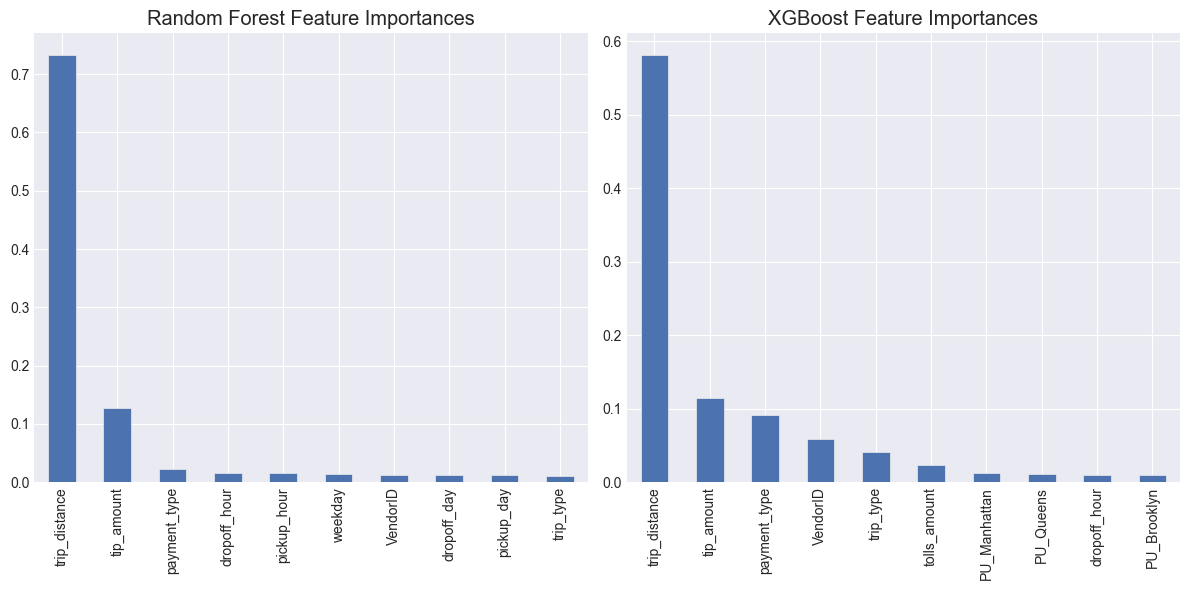

In [33]:
rf_importances = pd.Series(rf_model.feature_importances_,index=X.columns)
xgb_importances = pd.Series(xgb_model.feature_importances_,index=X.columns)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
rf_importances.nlargest(10).plot(kind='bar', title='Random Forest Feature Importances')
plt.subplot(1, 2, 2)
xgb_importances.nlargest(10).plot(kind='bar', title='XGBoost Feature Importances')
plt.tight_layout()
plt.show()

## 3.5
Specifying a parameter grid, containing potential parameter values so that the algorithm iterates over it.
Getting the best parameters as an output.

In [34]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)


print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.9}


Now, we calculate the Mean Square Error and Root Mean Squared Error of the model with the best parameters.

In [35]:
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 0.24
Root Mean Squared Error (RMSE): 0.39
